## Imports

In [64]:
#@title 1.1. Classes e funções

import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing') 
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import os
from scipy.signal import butter, filtfilt
from mypackages.eRDF import butter_lowpass_filter,DataProcessor, read_discus_fit_file
from mypackages.eRDF import optimize_constant, rw

from PIL import Image
import hyperspy.api as hs
import cv2
from mypackages.edp_processing import ImageAnalysis, ImageProcessing, peak_calibration
from mypackages.plot_style import set_plot_style

set_plot_style()

## Calibration, number density line and two-theta conversion

In [ ]:
#gold peak calibration
from scipy.signal import find_peaks

path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Au/Au_28_may_24'

end_name = 'Au_end.csv'
start_name = 'Au_start.csv'

df1 = pd.read_csv(os.path.join(path, start_name), header = None)
df2 = pd.read_csv(os.path.join(path, end_name), header = None)

data_start = df1[0].values
data_end = df2[0].values

peaks_start, _ = find_peaks(data_start, distance = 40, height=500)
peaks_end, _ = find_peaks(data_end, distance = 40, height=500)



calibration_start = peak_calibration(pixel_positions = peaks_start[3:7])
calibration_end = peak_calibration(pixel_positions = peaks_end[1:5])

calibration = (calibration_start +calibration_end)/2

peaks_end, _ = find_peaks(data_end, distance = 1, height=500)

plt.plot(data_start)
plt.plot(data_end)

In [ ]:
#gold peak calibration
from scipy.signal import find_peaks

path = '/home/ABTLUS/victor.secco/data_processing/ED/MnO/Mno.csv'

df1 = pd.read_csv(path, header = None)

data_start = df1[0].values
peaks_start, _ = find_peaks(data_start, distance = 10, height=50)



calibration_start = peak_calibration(pixel_positions = peaks_start[0:2])

calibration = calibration_start

plt.plot(data_start)
plt.scatter(peaks_start, data_start[peaks_start])

In [ ]:
1/37


In [ ]:
peaks_end

In [ ]:
#Conversion from pixel data to two-theta
wavelength = 1.5409

# Assuming 'data' index corresponds to 1/d values, you need to adjust how you calculate two_theta.
# Let's first convert indices to actual 1/d spacing if needed. This example assumes it directly corresponds.

# Correct calculation of two_theta from 1/d values
one_over_d = np.linspace(1, len(data_start), len(data_start))*(1/74.0625/(2*math.pi))  # This might need to be adjusted based on your actual d-spacing calculation
two_theta = 2 * np.degrees(np.arcsin(wavelength * (one_over_d) / 2))

plt.plot(two_theta, data_start, label="Intensity vs. 2θ")
#plt.scatter(two_theta[peaks[1:5]], data[peaks[1:5]], color='red', label="Peaks")  # Highlighting peaks, ensure peaks are correctly mapped
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

#print('The peaks found are 'f'{two_theta[peaks[1:5]]}')
# For the peak list, assuming 'peaks' correctly identifies indices in your q-space data

#with open(os.path.join(path, 'In2O3_peak_list.txt'), 'w') as arquivo:
#    for i in range(len(data)):  # Assuming 's' is meant to iterate over all data point
#          # Adjust this to match how you determine peaks in q-space
#        arquivo.write(f"{two_theta[i]}\t"f"{data[i]} \n")

dfexp = pd.DataFrame(columns=[two_theta, data_start]).T
dfexp.to_csv("/home/ABTLUS/victor.secco/data_processing/ED/MnO/Mno_two_theta.csv")

In [ ]:
dfexp

In [ ]:
#remaking the number density line
path = '/home/ABTLUS/victor.secco/data_processing/ED_data/CdSe_ePDF/W1/Jun_2024/'
file_path = os.path.join(path, 'Gr_Lorch.csv')

data = pd.read_csv(file_path, sep= '\t')

_Gr, _Gr_low_r = dp1.low_r_correction(data['gr'].values, nd*0.008, _r, r_cut = 2.39)
plt.plot(_r, _Gr)
plt.xlim(0,10)

file_path = os.path.join(path, 'Gr_Lorch_low_r.csv')
data = pd.DataFrame(np.transpose(np.array((_r, _Gr))))
data.rename(columns={0:'r',1:'gr'},inplace=True)
data['dr']=data['r']*0
data['dgr']=abs(data['gr']/20)
data.to_csv(file_path, sep='\t', float_format="%.10f", index='r')


## Calculating G(r)

In [ ]:
#Gr generation
lobato_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Lobato_2014.txt'


#ds = 0.00139501338 #Fe3O4-Oleyl
#ds = 0.001147 #AuNPs
#ds = 0.00121
ds = (calibration)/(2*math.pi) #AuNPs
#ds = 0.00096525376 #Fe3O4-Oam
nd = 1.4

CAS40 = {1: [14, 0.1343], 2: [13, 0.1192], 3: [20, 0.1495], 4: [20, 0.59696],}
CAS50 = {1: [14, 0.1653], 2: [13, 0.1004], 3: [20, 0.1265], 4: [8, 0.6204],}
CAS60 = {1: [14, 0.201], 2: [13, 0.0796], 3: [20, 0.099], 4: [8, 0.6323],}
CAS70 = {1: [14, 0.234], 2: [13, 0.0592], 3: [20, 0.0735], 4: [8, 0.6323],}
FS = {1: [14, 0.33], 2: [13, 0.0], 3: [20, 0.0], 4: [8, 0.66],}
CdSe =  {1: [34, 1], 2: [48, 1],}
Magnetite = {1: [26, 2], 2: [8, 3],}

path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Corning/Cintilador Novo/CAS40/ROI-4/Results/'
file_name = 'CAS40_ROI4.csv'
df = pd.read_csv(os.path.join(path, file_name), header = None)
                 #,decimal = ',')

raw_data = df[0].values +100
start = int(raw_data.shape[0]*0.035)
end =  int(raw_data.shape[0])
#ds = 3.6145889400000004/data.shape[0]

_beam = pd.read_csv("/home/ABTLUS/victor.secco/data_processing/ED_data/Background/Beam.txt", skiprows=12)
_beam = np.array(_beam)
_beam = _beam[:2999].reshape(2999,)

_OA = pd.read_csv("/home/ABTLUS/victor.secco/data_processing/ED_data/Background/OA_final.txt", skiprows=28)
_OA = np.array(_OA)
_OA = _OA[:2999].reshape(2999,)

#data = raw_data - (_beam-104889.67607+1514.52619)*0
#data = raw_data - (_OA-3400.125)*0.7


dp1 = DataProcessor(raw_data, lobato_path, start, end, ds, CAS40, region = 0.3)
 

_iq = dp1.iq
_sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0)
_fq_filtered = butter_lowpass_filter(_fq, fs = 50.0, cutoff = 2.0, order = 3)
#_r, _Gr_Lorch = dp1.calculate_Gr_Lorch(_fq, rmax = 50, dr = 0.01, a = 2.5, b = 0.5)
_r, _Gr = dp1.calculate_Gr(_fq, rmax=80, dr=0.02)

#_Gr, _Gr_low_r = dp1.low_r_correction(_Gr, nd*0.04, _r, r_cut = 1.15)
#_Gr_Lorch, _ = dp1.low_r_correction(_Gr_Lorch, nd*0.025, _r, r_cut = 2)

#_gr = _Gr_Lorch/(4 * math.pi * nd * _r)+1

_inverse_fq = dp1.inverse_fourier_transform(_Gr[37:], _r[37:], _fq_filtered, nd)

print(dp1.N)

_fq_normalized = (_fq_filtered-_fq_filtered.mean())/_fq_filtered.std()
_inverse_fq_normalized = (_inverse_fq-_inverse_fq.mean())/_inverse_fq.std()

dp1.plot_results(_fq, _fq, _Gr, _r, _Gr, 0)




"""
data = pd.DataFrame(np.transpose(np.array((_r, _Gr))))
data.rename(columns={0:'r',1:'gr'},inplace=True)
data['dr']=data['r']*0
data['dgr']=abs(data['gr']/20)

output_path = os.path.join(path, 'Gr_Fe2O3_Oam_ROI8.csv')

# Filter the DataFrame to include only rows where the r value is greater than 3
data.to_csv(output_path, sep='\t', float_format="%.10f", index=False)

datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _fq_filtered))))
datasq.rename(columns={0:'q',1:'sq'},inplace=True)
datasq.to_csv(os.path.join(path, 'Sq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')

datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq_normalized))))
datasq.rename(columns={0:'q',1:'sq'},inplace=True)
datasq.to_csv(os.path.join(path, 'ISq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')
"""



In [ ]:
#Gr generation
lobato_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Lobato_2014.txt'


ds = (calibration)/(2*math.pi)
nd = 1.4

CdSe =  {1: [34, 1], 2: [48, 1],}

path = '/home/ABTLUS/victor.secco/data_processing/ED_data/CdSe_ePDF/W1/Jun_2024/'
file_name = 'ROI1.csv'
df = pd.read_csv(os.path.join(path, file_name), header = None)

raw_data = df[0].values
start = int(raw_data.shape[0]*0.03)
end =  int(raw_data.shape[0]*0.8)

_OA = pd.read_csv("/home/ABTLUS/victor.secco/data_processing/ED_data/Background/OA_final.txt", skiprows=28)
_OA = np.array(_OA)
_OA = _OA[:3000].reshape(3000,)

dp1 = DataProcessor(raw_data, lobato_path, start, end, ds, CdSe, region = 0.3)

_iq = dp1.iq
_, _fq = dp1.calculate_SQ_PhiQ(_iq, 0)
_r, _Gr = dp1.calculate_Gr(_fq, rmax=80, dr=0.009)


#Subtracting background
data = raw_data #- (_OA)*0.01*0.8
#data = data + abs(raw_data[-1] - data[-1])
start = int(data.shape[0]*0.03)
end =  int(data.shape[0]*0.65)

dp2 = DataProcessor(data, lobato_path, start, end, ds, CdSe, region = 0.3)

_iq_bck = dp2.iq
_, _fq_bck = dp2.calculate_SQ_PhiQ(_iq_bck, 0)
_r_bck, _Gr_bck = dp2.calculate_Gr(_fq_bck, rmax=200, dr=0.012)

f, (ax1, ax2) = plt.subplots(2,1, figsize = (15,5))

ax1.plot(dp1.q, _fq, label = "original")
ax1.plot(dp2.q, _fq_bck, label = "background sub")
#ax1.set_xlim(1900,2000)
#ax1.set_ylim(0,50)

ax2.plot(_r, _Gr, label = "original")
ax2.plot(_r_bck, _Gr_bck+3, label = "background sub")
ax2.set_xlim(0,20)

plt.show()


data = pd.DataFrame(np.transpose(np.array((_r_bck, _Gr_bck))))
data.rename(columns={0:'r',1:'gr'},inplace=True)
data['dr']=data['r']*0
data['dgr']=abs(data['gr']/20)

output_path = os.path.join(path, 'Gr_14.56A.csv')

# Filter the DataFrame to include only rows where the r value is greater than 3
data.to_csv(output_path, sep='\t', float_format="%.10f", index=False)


## Nice plots

NameError: name 'dp1' is not defined

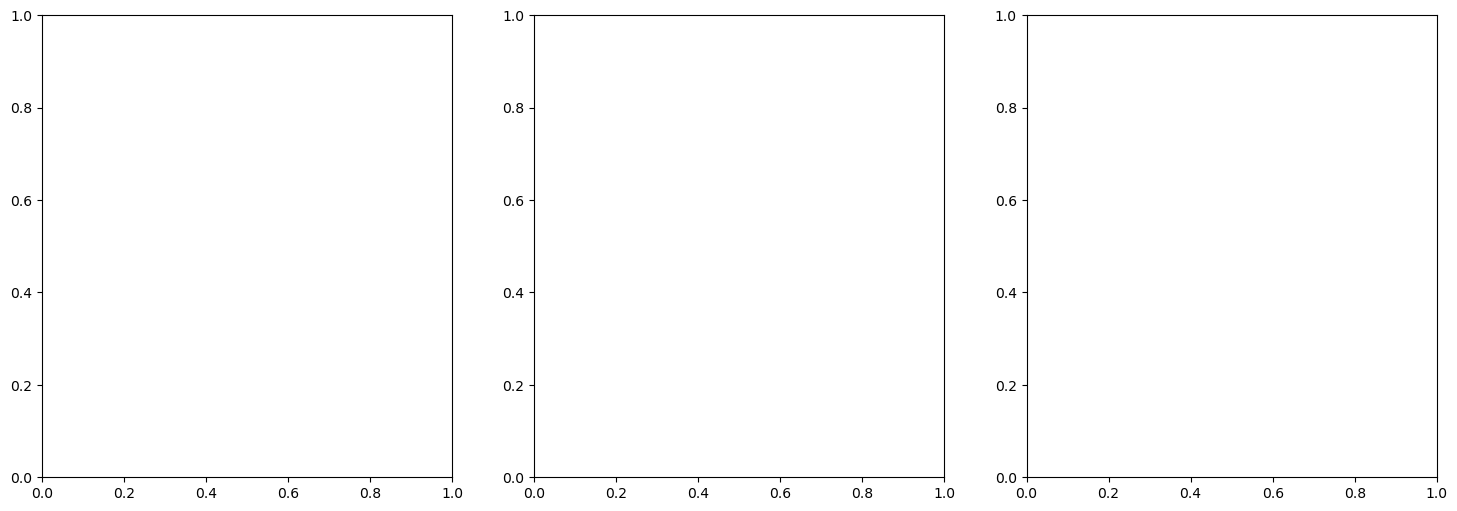

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import FuncFormatter

# Create the main plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot on ax1
ax1.plot(dp1.q, dp1.iq, label='I(Q)')
ax1.plot(dp1.q, dp1.autofit, label='Autofit')
ax1.set_title('Ajustando I(Q)')
ax1.set_xlabel(r'Q ($\rm\AA^{-1}$)')
ax1.set_ylabel('Intensidade')
ax1.set_xlim(0, 18)
ax1.set_xticks(np.arange(0, 19, 3))

def thousands_formatter(x, pos):
    return f'{x*1e-3:.0f}k'

ax1.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Plot on ax2
ax2.plot(dp1.q, _fq, color='black')
ax2.set_title('Calculando S(Q)')
ax2.set_xlabel(r'Q ($\rm\AA^{-1}$)')
ax2.set_ylabel('Q[S(Q)-1]')
ax2.set_xlim(1, 18)
ax2.set_xticks(np.arange(0, 19, 3))

# Plot on ax3
ax3.plot(_r, _Gr, label='tan(x)', color='blue')
ax3.set_title('Calculando a PDF')
ax3.set_xlabel(r'r ($\rm\AA$)')
ax3.set_ylabel(r'G(r) ($\rm\AA^{-2}$)')
ax3.set_xlim(0, 40)
plt.ylim(-7,10)

# Create an inset on ax3
axins = inset_axes(ax3, width="30%", height="30%", loc='upper right')  # Change size and location as needed

# Define the zoomed-in region
x1, x2, y1, y2 = 0, 2, -6, 9
axins.plot(_r, _Gr, color='blue')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Draw a rectangle on the main plot to show the region
mark_inset(ax3, axins, loc1=2, loc2=4, fc="none", ec="red")

# Adjust layout and space between plots
plt.subplots_adjust(wspace=0.4)  # Adjust this value if needed

# Save and show the plot
#plt.savefig("/home/ABTLUS/victor.secco/data_processing/Imagens/iq_sq_gr_inset.png", dpi=400)
plt.show()


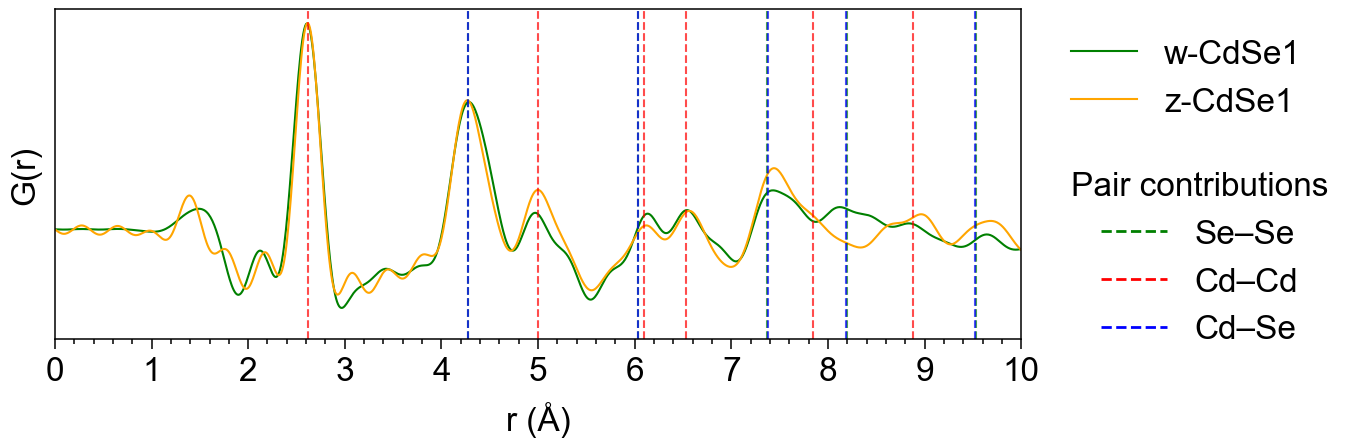

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 5))

# Plot G(r) curves
ax.plot(r_w2, gr_w2 * 1.55, label='w-CdSe1', color='green')
ax.plot(r_p5, gr_p5, label='z-CdSe1', color='orange')

# Vertical lines
for peak in peak_r_SeSe:
    ax.axvline(x=peak, color='green', linestyle='--', alpha=0.7)
for peak in peak_r_CdCd:
    ax.axvline(x=peak, color='red', linestyle='--', alpha=0.7)
for peak in peak_r_CdSe:
    ax.axvline(x=peak, color='blue', linestyle='--', alpha=0.7)

# First legend (curve labels) - outside right
curve_legend = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)
ax.add_artist(curve_legend)

# Second legend (pair contributions) - below curve legend
pair_lines = [
    Line2D([0], [0], color='green', linestyle='--', lw=2, label='Se–Se'),
    Line2D([0], [0], color='red', linestyle='--', lw=2, label='Cd–Cd'),
    Line2D([0], [0], color='blue', linestyle='--', lw=2, label='Cd–Se'),
]
ax.legend(handles=pair_lines, loc='upper left', bbox_to_anchor=(1.02, 0.6), frameon=False, title='Pair contributions')

# Adjust layout to fit legends
fig.subplots_adjust(right=0.75)

# Plot labels and style
ax.set_xlabel('r (Å)')
ax.set_ylabel('G(r)')
ax.set_xlim(0, 10)
ax.set_ylim(-3, 6)
ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks([])
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))

# Plot the pair distribution functions
plt.plot(rgui, SeSe, label="Se-Se pairs", color='green')
plt.plot(rgui, CdCd, label="Cd-Cd pairs", color='red')
plt.plot(rgui, CdSe, label="Cd-Se pairs", color='blue')

# Vertical lines up to the profile height
for peak in peak_r_SeSe:
    idx = np.searchsorted(rgui, peak)
    plt.vlines(x=peak, ymin=0, ymax=SeSe[idx], color='green', linestyle='--', alpha=0.7)

for peak in peak_r_CdCd:
    idx = np.searchsorted(rgui, peak)
    plt.vlines(x=peak, ymin=0, ymax=CdCd[idx], color='red', linestyle='--', alpha=0.7)

for peak in peak_r_CdSe:
    idx = np.searchsorted(rgui, peak)
    plt.vlines(x=peak, ymin=0, ymax=CdSe[idx], color='blue', linestyle='--', alpha=0.7)

# Labels and legend
plt.xlabel(r'r $\rm{(\AA)}$')
plt.ylabel(r'G(r) ($\rm{\AA^{-2}}$)')
plt.xlim(2, 20)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/W1/Jun_2024/PCA/fq_pca_CdSe_W1.csv", sep='\t')
q = df['q']
fq = df['fq']

# Set font size
plt.rc('font', size=33) 

# Create plot
fig, axes = plt.subplots(1, 1, figsize=(14, 5))
axes.plot(q, fq)
axes.set_xlabel(r'$\rm Q (\AA^{-1})$')
axes.set_ylabel('Q[S(Q)-1]')
axes.set_xlim(1.4, 16.5)
axes.legend()

# Remove y-axis ticks and labels
axes.set_yticks([])
axes.set_yticklabels([])

# Adjust layout
plt.tight_layout()
plt.show()


## Polynomial fitting

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


# Normalize the data
norm_data = data[start:end] / (dp1.N * dp1.fq_sq)
norm_data = norm_data * dp1.q

degree = 10
# Fit the polynomial
coefficients = np.polyfit(dp1.q, norm_data, degree)
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the polynomial fit
x_fit = np.linspace(dp1.q.min(), dp1.q.max(), len(norm_data))
y_fit = polynomial(x_fit)

# Calculate _fq_poly and apply Butterworth lowpass filter
fq_poly = norm_data - y_fit
fq_poly = butter_lowpass_filter(_fq_poly, fs=20.0, cutoff=1.0, order=3)

# Calculate _Gr_Poly
r, Gr_Poly = dp1.calculate_Gr(_fq_poly, rmax=50, dr=0.01)

# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot polynomial fit to the data
axs[0].scatter(dp1.q, norm_data, color='red', label='Data Points')
axs[0].plot(x_fit, y_fit, color='blue', label=f'Polynomial Fit: Degree {degree}')
axs[0].set_title('Polynomial Fit to Data')
axs[0].set_xlabel('Q')
axs[0].set_ylabel('Normalized Data')
axs[0].legend()
axs[0].grid(True)

# Plot G(r)
axs[1].plot(_r, fq_poly, color='green', label='G(r) from Filtered F(Q)')
axs[1].set_title('G(r) from Filtered F(Q)')
axs[1].set_xlabel('r')
axs[1].set_ylabel('G(r)')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


NameError: name 'data' is not defined

In [ ]:

plt.plot(_r, _Gr_Poly)
plt.plot(_r, _Gr_Poly)
plt.xlim(0, 20)


data = pd.DataFrame(np.transpose(np.array((_r, _Gr_Poly))))
data.rename(columns={0:'r',1:'gr'},inplace=True)
data['dr']=data['r']*0
data['dgr']=abs(data['gr']/20)
data.to_csv(os.path.join(path, 'Gr_without_q.csv'), sep='\t',float_format="%.10f", index='r')

#datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _fq_poly))))
#datasq.rename(columns={0:'q',1:'sq'}, inplace=True)
#datasq.to_csv(os.path.join(path, 'Sq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')

#datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq_normalized))))
#datasq.rename(columns={0:'q',1:'sq'},inplace=True)
#datasq.to_csv(os.path.join(path, 'ISq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')


## Mean of 8 regions

In [ ]:
# Specify the directory containing the CSV files
folder_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/CdSe_ePDF/L2_CdSe/Results'

# List all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.startswith('Stacked')]

# Check to ensure exactly 8 CSV files are present
if len(csv_files) != 8:
    raise ValueError("There should be exactly 8 CSV files in the folder.")

# Initialize a list to store DataFrames
data_frames = []

# Process each file
for file in csv_files:
    # Construct the full file path
    file_path = os.path.join(folder_path, file)
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Add DataFrame to the list
    data_frames.append(df)

# Concatenate all DataFrames along the columns (axis=1) and compute the mean along the columns
resultant_mean = pd.concat(data_frames, axis=1).mean(axis=1)

# Save the mean values to a text file
with open(os.path.join(folder_path, 'average.csv'), 'w') as f:
    for mean in resultant_mean:
        f.write(f'{mean}\n')



## Fitting plots and Rw optimization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mypackages.eRDF import read_discus_fit_file, calculate_rw, optimize_constant


dp1 = DataProcessor(raw_data, lobato_path, start, end, ds, CAS40, region = 0.3)

df_exp = read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/ED_data/CdSe_ePDF/P5/Results/gr_PCA_CdSe_P5.fit')
r_fit = df_exp['r'].values
Gr_fit = df_exp['gr'].values
_inverse_fq = dp1.inverse_fourier_transform(Gr_fit, r_fit)

# Plot the experimental and fitted G(r) values
plt.figure(figsize=(10, 6))
plt.plot(r_fit, Gr_fit, label=r'G(r) $\rm{CdSe_{calc}}$', color='red')
plt.plot(_r, _Gr/5.8, label=r'G(r) $\rm{CdSe_{calc}}$', color='black')
plt.xlabel(r'r $\rm{(\AA)}$')
plt.ylabel(r'G(r) ($\rm{\AA^{-2}}$)')
plt.xlim(0, 35)
plt.legend(frameon=False)


In [ ]:
index = np.where(r == 30)[0]

print(index)

In [ ]:
import pandas as pd
import numpy as np
from mypackages.eRDF import read_discus_fit_file, calculate_rw, optimize_constant
%matplotlib widget


start = 200
end = 2849

df_exp = read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/P5/Gr/gr_PCA_CdSe_P5.grobs')
r = df_exp['r'].values[start:]
GrtruncP5 = df_exp['gr'].values[start:]

df_fit = read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/P5/Results/gr_PCA_CdSe_P5.fit')
GrcalcP5 = df_fit['gr'].values[start:]

optimized_constant = optimize_constant(GrtruncP5[:end], GrcalcP5[:end], initial_guess=0.1)
rw_optimized = calculate_rw(GrtruncP5[:end], GrcalcP5[:end], optimized_constant)

df_exp = read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/W1/Jun_2024/Gr/gr_PCA_CdSe_W1.grobs')
r = df_exp['r'].values[start:]
GrtruncW1= df_exp['gr'].values[start:]

df_fit = read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/W1/Jun_2024/Gr/calc.9999')
GrcalcW1= df_fit['gr'].values[start:]

optimized_constantW = optimize_constant(GrtruncW1[:end], GrcalcW1[:end], initial_guess=0.1)
rw_optimizedW = calculate_rw(GrtruncW1[:end], GrcalcW1[:end], optimized_constant)

# Plot the experimental and fitted G(r) values
plt.figure(figsize=(8, 8))
plt.scatter(r[::3], GrtruncP5[::3] , label=r'G(r) $\rm{CdSe_{exp}}$', s = 20, facecolors='none', edgecolors='b')
plt.plot(r, GrcalcP5, label=r'G(r) $\rm{CdSe_{calc}}$', color='red')

plt.xlabel(r'r $\rm{(\AA)}$')
plt.ylabel(r'G(r) ($\rm{\AA^{-2}}$)')
plt.xlim(2, 35)
plt.legend(frameon=False)

plt.scatter(r[::3], GrtruncW1[::3]*1.7 -6, label=r'G(r) $\rm{CdSe_{exp}}$', s = 20, facecolors='none', edgecolors='b')
plt.plot(r, GrcalcW1*1.7-6, label=r'G(r) $\rm{CdSe_{calc}}$', color='red')



# Add Rw as text in the plot
plt.text(0.75, 0.69, f'Rw = {rw_optimized*100:.1f}%', transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')
# Add Rw as text in the plot
plt.text(0.75, 0.3, f'Rw = {rw_optimizedW*100:.1f}%', transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')

# Add Rw as text in the plot
plt.text(0.1, 0.79, f'z-CdSe SF-density = 20%', transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')
# Add Rw as text in the plot
plt.text(0.1, 0.37, f'w-CdSe SF-density = 25%', transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')


plt.savefig("/home/ABTLUS/victor.secco/data_processing/Imagens/wz-cdse_gr.png", dpi = 600)
# Show the plot
plt.show()


In [61]:
import os
import pandas as pd

pdfgui_path = r"E:\data_processing\data\processed\epdf\CdSe\W1\Gr"
pdfgui_names = [x for x in os.listdir(pdfgui_path) if x.endswith("grcalc")]

# Initialize an empty list to hold the dataframes
df_list = []

for i, file in enumerate(pdfgui_names):
    # Read the dataframe
    df = pd.read_csv(os.path.join(pdfgui_path, file), skiprows=4, sep=' ')
    
    # Rename the columns to include the filename
    if i == 0:
        df.columns = [f"{file}_col1", f"{file}_col2"]
    else:
        # Drop the first column and rename the remaining columns
        df = df.iloc[:, 1:]
        df.columns = [f"{file}_col2"]

    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all the dataframes along the columns (axis=1)
final_df = pd.concat(df_list, axis=1)

# Optionally, reset the index if needed
final_df.reset_index(drop=True, inplace=True)

rgui = final_df["Cd-Cd.grcalc_col1"].values+0.06

scale = 0.8*(1/rgui)
SeSe = final_df["Cd-Cd.grcalc_col2"].values*scale
CdCd = final_df["Cd-Se.grcalc_col2"].values*scale
CdSe = final_df["Se-Se.grcalc_col2"].values*scale

from scipy.signal import find_peaks

peaks_SeSe, _ = find_peaks(SeSe)
peaks_CdCd, _ = find_peaks(CdCd, distance=10, 
                           height=0.1,
                           prominence=0.1)
peaks_CdSe, _ = find_peaks(CdSe)

peak_r_SeSe = rgui[peaks_SeSe]
peak_r_CdCd = rgui[peaks_CdCd]
peak_r_CdSe = rgui[peaks_CdSe]

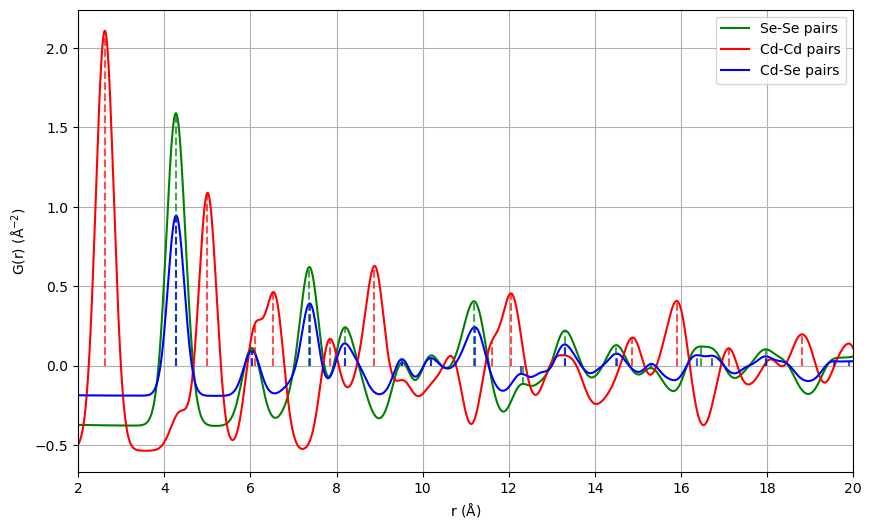

In [62]:
plt.figure(figsize=(10, 6))

# Plot the pair distribution functions
plt.plot(rgui, SeSe, label="Se-Se pairs", color='green')
plt.plot(rgui, CdCd, label="Cd-Cd pairs", color='red')
plt.plot(rgui, CdSe, label="Cd-Se pairs", color='blue')


manual_cdcd_peaks = [6.1, 11.6] 
peak_r_CdCd = np.append(peak_r_CdCd, manual_cdcd_peaks)
peak_r_CdCd = np.sort(peak_r_CdCd)

# Vertical lines up to the profile height
for peak in peak_r_SeSe:
    idx = np.searchsorted(rgui, peak)
    plt.vlines(x=peak, ymin=0, ymax=SeSe[idx], color='green', linestyle='--', alpha=0.7)

for peak in peak_r_CdCd:
    idx = np.searchsorted(rgui, peak)
    plt.vlines(x=peak, ymin=0, ymax=CdCd[idx], color='red', linestyle='--', alpha=0.7)

for peak in peak_r_CdSe:
    idx = np.searchsorted(rgui, peak)
    plt.vlines(x=peak, ymin=0, ymax=CdSe[idx], color='blue', linestyle='--', alpha=0.7)

# Labels and legend
plt.xlabel(r'r $\rm{(\AA)}$')
plt.ylabel(r'G(r) ($\rm{\AA^{-2}}$)')
plt.xlim(2, 20)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot with its own label
scatter = plt.scatter(r, GrtruncW1, label=r'G(r) $\rm{CdSe_{exp}}$', color='blue', s=20)
plt.scatter(r, GrtruncP5+8, label=r'G(r) $\rm{CdSe_{exp}}$', color='blue', s = 20)

# Offset for the line plots
offset = -5
# Add vertical lines for Se-Se peaks
for peak in peak_r_SeSe:
    plt.axvline(x=peak, color='green', linestyle='-', alpha=0.7)

# Add vertical lines for Cd-Cd peaks
for peak in peak_r_CdCd:
    plt.axvline(x=peak, color='red', linestyle='-', alpha=0.7)

# Add vertical lines for Cd-Se peaks
for peak in peak_r_CdSe:
    plt.axvline(x=peak, color='blue', linestyle='-', alpha=0.7)
# Labels and axes limits
plt.xlabel(r'r $\rm{(\AA)}$')
plt.ylabel(r'G(r) ($\rm{\AA^{-2}}$)')
plt.xlim(2, 10)

# Creating the legend for the scatter plot
scatter_legend = plt.legend([scatter], [r'G(r) $\rm{CdSe_{exp}}$'], loc='upper right')

# Adding the legend for the line plots separately
plt.legend([line1, line2, line3], ['Cd-Cd pairs', 'Cd-Se pairs', 'Se-Se pairs'], loc='lower right')

# Adding the first scatter legend back to the plot
plt.gca().add_artist(scatter_legend)

# Show the plot
plt.show()


In [ ]:
p5 = pd.read_csv('/home/ABTLUS/victor.secco/data_processing/ED_data/CdSe_ePDF/P5/PCA/fq_pca_CdSe_P5.csv',sep = '\t')
w1 = pd.read_csv('/home/ABTLUS/victor.secco/data_processing/ED_data/CdSe_ePDF/W1/Jun_2024/PCA/fq_pca_CdSe_W1.csv', sep = '\t')


plt.figure(figsize=(8, 8.75))
plt.plot(p5['q'].values, p5['sq'].values/p5['q'].values-2, label = 'z-CdSe', color = 'blue')
plt.plot(w1['q'].values, w1['fq'].values/w1['q'].values*1.8+1, label = 'w-CdSe', color = 'black')


plt.legend(frameon=False)
plt.xlabel(r'Q $\rm{(\AA^{-1})}$')
plt.ylabel(r'S(Q) ($\rm{\AA^{-1}}$)')


plt.xticks(np.arange(0,18,2))
plt.xlim(1.1,17)
plt.tight_layout()
plt.savefig("/home/ABTLUS/victor.secco/data_processing/Imagens/B-MRS 2024/wz-cdse_sq.jpg", dpi = 600)
plt.show()

In [ ]:
obs = pd.read_csv('/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/Maghemite/Fe2O3_OAm/fq_pca_fe2o3_oam.csv', sep = '\t')
calc = read_discus_fit_file('//home/ABTLUS/victor.secco/data_processing/EXP2PDF/16.927.iqobs')


optimized_constantW = optimize_constant(obs['fq'], calc['gr'], initial_guess=1)

plt.figure(figsize =(10,5))
plt.plot(obs['q'], obs['fq']*1.45)
plt.plot(calc['r'], calc['gr'])
plt.xlim(1,17)

In [2]:
df_fit = read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/P5/PCA/REF_KID.fq')
#df_fit
df_obs = pd.read_csv("/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/P5/PCA/fq_pca_CdSe_P5.csv", sep = '\t')


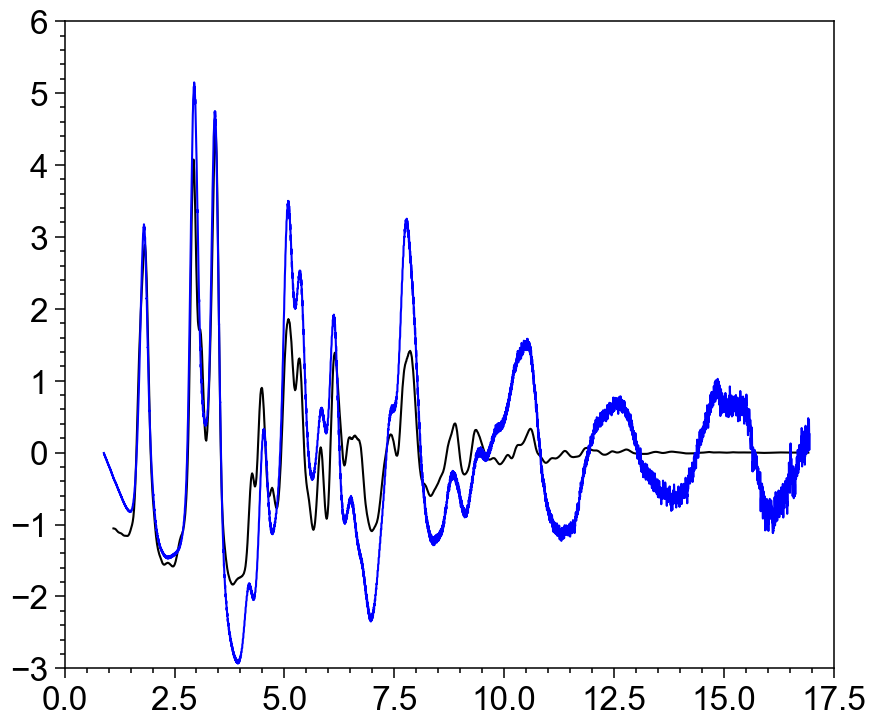

In [4]:
plt.plot(df_fit['r'].values, df_fit['gr'].values)
plt.plot(df_obs['q'].values, df_obs['fq'].values)
plt.show()

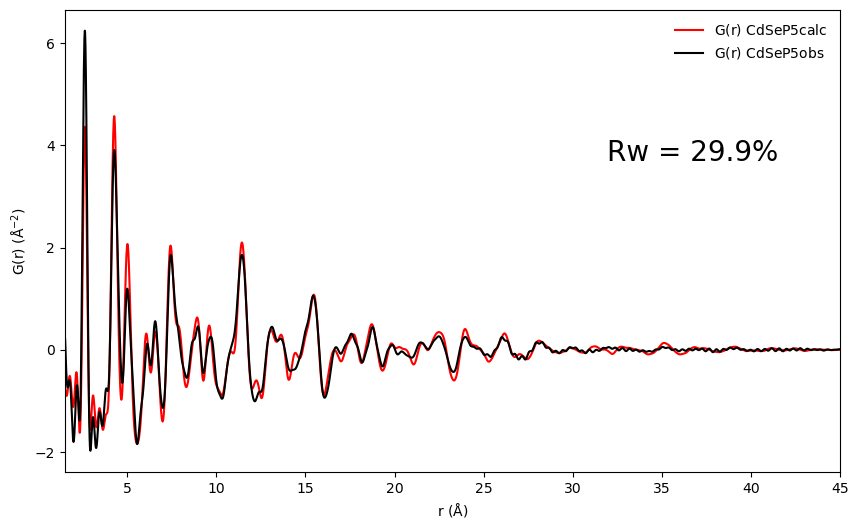

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mypackages.eRDF import read_discus_fit_file, calculate_rw, optimize_constant
import numpy as np



# Define the range of indices
index_range = slice(150, 4500)
df_fit = read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/data/raw/ED/CdSe_ePDF/P5/Gr/indi.9999')
r_fit = df_fit['r'].values[index_range]
Gr_fit = df_fit['gr'].values[index_range]

df_exp = read_discus_fit_file('/home/ABTLUS/victor.secco/data_processing/data/raw/ED/CdSe_ePDF/P5/Gr/gr_PCA_CdSe_P5.grobs')
                      #sep = '\t')
r_exp = df_exp['r'].values[index_range]
Gr_exp = df_exp['gr'].values[index_range]

# Optimize the constant
optimized_constant = optimize_constant(Gr_exp, Gr_fit, initial_guess=0.1)

# Calculate Rw
rw_optimized = calculate_rw(Gr_exp, Gr_fit, optimized_constant)

# Plot the experimental and fitted G(r) values
plt.figure(figsize=(10, 6))
plt.plot(r_fit, Gr_fit, label=r'G(r) $\rm{CdSe P5 calc}$', color='red')
plt.plot(r_exp, Gr_exp*optimized_constant, label=r'G(r) $\rm{CdSe P5 obs}$', color='black')
plt.xlabel(r'r $\rm{(\AA)}$')
plt.ylabel(r'G(r) ($\rm{\AA^{-2}}$)')
plt.xlim(1.5, 45)
plt.legend(frameon=False)

# Add Rw as text in the plot
plt.text(0.7, 0.72, f'Rw = {rw_optimized*100:.1f}%', transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')

# Show the plot
plt.show()


## Multiple ePDF data generation

In [ ]:

combined_data = pd.DataFrame()


path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Corning/CAS70/Results/'
root_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Corning/CAS70/'
for file_name in os.listdir(path):
  if file_name.endswith('.csv'):
    file_path = os.path.join(path, file_name)
    df = pd.read_csv(file_path, sep = '\t', header = None)
    df.rename(columns={0: file_name}, inplace=True)
    combined_data = pd.concat([combined_data, df], axis = 1)

gr_data = pd.DataFrame()
sq_data = pd.DataFrame()

for i in combined_data.columns:
  dp1 = DataProcessor(combined_data[i], lobato_path, start, end, ds, CAS70, region = 0)
  _iq = dp1.iq
  _sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0.2)
  _r, _Gr = dp1.calculate_Gr_Lorch(_fq, rmax = 50, dr = math.pi/dp1.q.max(), a = 2.0, b = 0.5)
  _Gr, _ = dp1.low_r_correction(_Gr, nd, _r, r_cut = 1.2)
  _inverse_fq = dp1.inverse_fourier_transform(_Gr, _r, _fq, nd)
  _Gr = pd.DataFrame(_Gr, columns = [i[:-4]], index = _r)
  gr_data= pd.concat([gr_data, _Gr], axis = 1)
  _fq = pd.DataFrame(_fq, columns = [i[:-4]], index = dp1.q)
  sq_data = pd.concat([sq_data, _fq], axis = 1)

sq_data.to_csv(os.path.join(path, 'Sq_CAS70.csv'), sep='\t',float_format="%.10f", index='r')

In [ ]:
#Gr generation
lobato_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Lobato_2014.txt'

#ds = 0.00139501338 #Fe3O4-Oleyl
#ds = 0.001147 #AuNPs
ds = 0.007584086757763026/(2*math.pi) #AuNPs
#ds = 0.00096525376 #Fe3O4-Oam
nd = 0.08673


CAS40 = {1: [14, 0.1343], 2: [13, 0.1192], 3: [20, 0.1495], 4: [20, 0.59696],}
CAS50 = {1: [14, 0.1653], 2: [13, 0.1004], 3: [20, 0.1265], 4: [8, 0.6204],}
CAS60 = {1: [14, 0.201], 2: [13, 0.0796], 3: [20, 0.099], 4: [8, 0.6323],}
CAS70 = {1: [14, 0.234], 2: [13, 0.0592], 3: [20, 0.0735], 4: [8, 0.6323],}
FS = {1: [14, 0.33], 2: [13, 0.0], 3: [20, 0.0], 4: [8, 0.66],}
Magnetite = {1: [26, 2], 2: [8, 3],}

#Si	Al	Ca	O
#CAS 40 0.134333333	0.1192	0.1495	0.596966667
#CAS 50 0.165333333	0.1004	0.1265	0.607766667
#CAS 60 0.201	0.0796	0.099	0.6204
#CAS 70 0.235	0.0592	0.0735	0.6323
#FS 0.333333333			0.666666667

path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/Results/'
file_name = 'Fe2O3_Oleyl.csv'

df = pd.read_csv(os.path.join(path, file_name), header = None)
                 #,decimal = ',')

data = df[0].values
start = int(data.shape[0]*0.05)
end =  int(data.shape[0]*0.8)
#ds = 3.6145889400000004/data.shape[0]

dp1 = DataProcessor(data, lobato_path, start, end, ds, Magnetite, region = 0)
 
_iq = dp1.iq
_sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0.2)
_fq_filtered = butter_lowpass_filter(_fq, fs = 30.0, cutoff = 2.0, order = 3)
_r, _Gr = dp1.calculate_Gr_Lorch(_fq_filtered, rmax = 50, dr = math.pi/dp1.q.max(), a = 1.6, b = 0.5)
first_peak = np.where((_r > 1.6) & (_r < 2.5), _Gr, 0)
second_peak = np.where((_r > 2.5) & (_r < 4), _Gr, 0)
third_peak = np.where((_r > 4) & (_r < 7), _Gr, 0)
_Gr, _Gr_low_r = dp1.low_r_correction(_Gr, nd*0.2, _r, r_cut = 1.7)



#_Gr2= _Gr*0.8

_gr = _Gr/(4 * math.pi * nd * _r)+1

_inverse_fq = dp1.inverse_fourier_transform(_Gr, _r, _fq_filtered, nd)
_inverse_fq1 = dp1.inverse_fourier_transform(first_peak, _r, _fq_filtered, nd)
_inverse_fq2 = dp1.inverse_fourier_transform(second_peak, _r, _fq_filtered, nd)
_inverse_fq3 = dp1.inverse_fourier_transform(third_peak, _r, _fq_filtered, nd)
#inverse_sq = (_inverse_fq/dp1.s)+1

print(dp1.N)


dp1.plot_results(_fq, _inverse_fq, _Gr, _r, _Gr, 0)

"""
data = pd.DataFrame(np.transpose(np.array((_r, _Gr))))
data.rename(columns={0:'r',1:'gr'},inplace=True)
data['dr']=data['r']*0
data['dgr']=abs(data['gr']/20)
data.to_csv(os.path.join(path, 'Gr_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')

datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq))))
datasq.rename(columns={0:'q',1:'sq'},inplace=True)
datasq.to_csv(os.path.join(path, 'Sq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')
"""

In [ ]:
lobato_path = 'Lobato_2014.txt'

#ds = 0.00139501338 #Fe3O4-Oleyl
#ds = 0.001147 #AuNPs
ds = 0.00120486298 #AuNPs
#ds = 0.00096525376 #Fe3O4-Oam
nd = 0.08673


CAS40 = {1: [14, 0.1343], 2: [13, 0.1192], 3: [20, 0.1495], 4: [20, 0.59696],}
CAS50 = {1: [14, 0.1653], 2: [13, 0.1004], 3: [20, 0.1265], 4: [8, 0.6204],}
CAS60 = {1: [14, 0.201], 2: [13, 0.0796], 3: [20, 0.099], 4: [8, 0.6323],}
FS = {1: [14, 0.33], 2: [13, 0.0], 3: [20, 0.0], 4: [8, 0.66],}


path = 'Binning/Results'
names = [x for x in os.listdir(path) if x.endswith('.csv')]

Grs = []
fqs = []
qs = []
_rs = []

for name in names:   
    df = pd.read_csv(os.path.join(path, name), sep = '\t', header = None)         
    start = int(df.shape[0]*0.05)
    end =  int(df.shape[0]*0.8333333333333334)
    ds = 3.6145889400000004/df.shape[0]
    dp1 = DataProcessor(df[0], lobato_path, start, end, ds, FS, region = 0.2)
    _iq = dp1.iq
    _sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0.2)
    _fq_filtered = butter_lowpass_filter(_fq, fs = 30.0, cutoff = 2.0, order = 3)
    _r, _Gr = dp1.calculate_Gr_Lorch(_fq_filtered, rmax = 50, dr = math.pi/dp1.q.max(), a = 1.6, b = 0.5)
    _Gr, _Gr_low_r = dp1.low_r_correction(_Gr, nd*0.65, _r, r_cut = 1)
    _gr = _Gr/(4 * math.pi * nd * _r)+1
    Grs.append(_Gr)
    fqs.append(_fq)
    _rs.append(_r)
    qs.append(dp1.q)
    _inverse_fq = dp1.inverse_fourier_transform(_Gr, _r, _fq_filtered, nd)

f, ax = plt.subplots(2,1, figsize = (10,5))
for i in range(len(Grs)):
    ax[0].plot(qs[i], fqs[i], label = names[i][10:-4])
    #ax[0].set_xlim(11.5,13.5)
    #ax[0].set_ylim(0.2,0.7)
    ax[0].legend()
    ax[1].plot(_rs[i], Grs[i])
    ax[1].set_xlim(1,5)


plt.show()
#dp1.plot_results(_fq, _fq2, _Gr, _r, _Gr2, 0)


#data = pd.DataFrame(np.transpose(np.array((_r, _Gr))))
#data.rename(columns={0:'r',1:'gr'},inplace=True)
#data['dr']=data['r']*0
#data['dgr']=abs(data['gr']/20)
#data.to_csv(os.path.join(path, 'Gr_'f{file_path}'), sep='\t',float_format="%.10f", index='r')

#datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq))))
#datasq.rename(columns={0:'q',1:'sq'},inplace=True)
#datasq.to_csv(os.path.join(path, 'Sq_'f'{file_path}'), sep='\t',float_format="%.10f", index='r')

In [ ]:
lobato_path = 'Lobato_2014.txt'

#ds = 0.00139501338 #Fe3O4-Oleyl
#ds = 0.001147 #AuNPs
ds = 0.00120486298 #AuNPs
#ds = 0.00096525376 #Fe3O4-Oam
nd = 0.08673


CAS40 = {1: [14, 0.1343], 2: [13, 0.1192], 3: [20, 0.1495], 4: [20, 0.59696],}
CAS50 = {1: [14, 0.1653], 2: [13, 0.1004], 3: [20, 0.1265], 4: [8, 0.6204],}
CAS60 = {1: [14, 0.201], 2: [13, 0.0796], 3: [20, 0.099], 4: [8, 0.6323],}
FS = {1: [14, 0.33], 2: [13, 0.0], 3: [20, 0.0], 4: [8, 0.66],}


path = 'Binning/Results'
names = [x for x in os.listdir(path) if x.endswith('.csv')]

Grs = []
fqs = []
qs = []
_rs = []

for name in names:   
    df = pd.read_csv(os.path.join(path, name), sep = '\t', header = None)         
    start = int(df.shape[0]*0.05)
    end =  int(df.shape[0]*0.8333333333333334)
    ds = 3.6145889400000004/df.shape[0]
    dp1 = DataProcessor(df[0], lobato_path, start, end, ds, FS, region = 0.2)
    _iq = dp1.iq
    _sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0.2)
    _fq_filtered = butter_lowpass_filter(_fq, fs = 30.0, cutoff = 2.0, order = 3)
    _r, _Gr = dp1.calculate_Gr_Lorch(_fq_filtered, rmax = 50, dr = math.pi/dp1.q.max(), a = 1.6, b = 0.5)
    _Gr, _Gr_low_r = dp1.low_r_correction(_Gr, nd*0.65, _r, r_cut = 1)
    _gr = _Gr/(4 * math.pi * nd * _r)+1
    Grs.append(_Gr)
    fqs.append(_fq)
    _rs.append(_r)
    qs.append(dp1.q)
    _inverse_fq = dp1.inverse_fourier_transform(_Gr, _r, _fq_filtered, nd)

f, ax = plt.subplots(2,1, figsize = (10,5))
for i in range(len(Grs)):
    ax[0].plot(qs[i], fqs[i], label = names[i][10:-4])
    #ax[0].set_xlim(11.5,13.5)
    #ax[0].set_ylim(0.2,0.7)
    ax[0].legend()
    ax[1].plot(_rs[i], Grs[i])
    ax[1].set_xlim(1,5)


plt.show()
#dp1.plot_results(_fq, _fq2, _Gr, _r, _Gr2, 0)


#data = pd.DataFrame(np.transpose(np.array((_r, _Gr))))
#data.rename(columns={0:'r',1:'gr'},inplace=True)
#data['dr']=data['r']*0
#data['dgr']=abs(data['gr']/20)
#data.to_csv(os.path.join(path, 'Gr_'f{file_path}'), sep='\t',float_format="%.10f", index='r')

#datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq))))
#datasq.rename(columns={0:'q',1:'sq'},inplace=True)
#datasq.to_csv(os.path.join(path, 'Sq_'f'{file_path}'), sep='\t',float_format="%.10f", index='r')

In [ ]:
ds = calibration / (2 * math.pi)
lobato_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Lobato_2014.txt'

CdSe =  {1: [34, 1], 2: [48, 1],}

# Define the path to the CSV files
path = '/home/ABTLUS/victor.secco/data_processing/ED_data/CdSe_ePDF/P5/Indiv_IQ/'

# Initialize a figure object with subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2x4 grid

# Flatten the axs array for easy indexing
axs = axs.flatten()

fq_poly_list = []

for i, file_name in enumerate(file_names):
    print(f"Processing file: {file_name}")
    # Read the CSV file
    df = pd.read_csv(os.path.join(path, file_name), header=None)
    raw_data = df[0].values
    
    # Define start and end indices
    start = int(raw_data.shape[0] * 0.03)
    end = int(raw_data.shape[0] * 0.8)
    
    # Initialize DataProcessor with the appropriate parameters
    dp1 = DataProcessor(raw_data, lobato_path, start, end, ds, CdSe, region=0.3)
    
    # Normalize the data
    norm_data = raw_data[start:end] / (dp1.N * dp1.fq_sq)
    norm_data = norm_data * dp1.q
    
    # Fit the polynomial
    degree = 12
    coefficients = np.polyfit(dp1.q, norm_data, degree)
    polynomial = np.poly1d(coefficients)
    
    # Generate x values for plotting the polynomial fit
    x_fit = np.linspace(dp1.q.min(), dp1.q.max(), len(norm_data))
    y_fit = polynomial(x_fit)
    
    # Calculate _fq_poly
    _fq_poly = norm_data - y_fit

    fq_poly_list.append(_fq_poly)
    
fq_poly_df = pd.DataFrame(fq_poly_list)

# Adjust layout and show the plot

plt.tight_layout()
plt.show()


In [ ]:
ds = calibration / (2 * math.pi)
lobato_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Lobato_2014.txt'
Magnetite = {1: [26, 3], 2: [8, 4]}

# Define the path to the CSV files
path = '/home/ABTLUS/victor.secco/data_processing/ED_data/CdSe_ePDF/P5/Indiv_IQ/'

fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2x4 grid

# Flatten the axs array for easy indexing
axs = axs.flatten()

file_names = [x for x in os.listdir(path) if x.endswith('indiv.csv')]
file_names.sort()

fq_list = []

# Loop through all CSV files in the directory
for i, file_name in enumerate(file_names):
    print(f"Processing file: {file_name}")
    # Read the CSV file
    df = pd.read_csv(os.path.join(path, file_name), header=None)
    raw_data = df[0].values
    
    # Define start and end indices
    start = int(raw_data.shape[0] * 0.03)
    end = int(raw_data.shape[0] * 0.8)
    
    # Initialize DataProcessor with the appropriate parameters
    dp1 = DataProcessor(raw_data, lobato_path, start, end, ds, CdSe, region=0.2)
    
    # Perform calculations
    _iq = dp1.iq
    _sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0.2)
    fq_list.append(_fq)
    _r, _Gr = dp1.calculate_Gr(_fq, rmax=80, dr=0.05)
    
    _Gr_Lorch, _ = dp1.low_r_correction(_Gr, ds * 0.025, _r, r_cut=2)
    
    # Plot the _fq result for this file on the corresponding subplot
    axs[i].plot(dp1.q, _fq)
    axs[i].axhline(0, color='black', linewidth=1, linestyle='--')
    axs[i].set_title(f'{file_name}')
    axs[i].set_xlabel('Q')
    axs[i].set_ylabel('Intensity')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Wavelet Transform

In [ ]:
time = np.linspace(0, 1, 2310)
plt.plot(time, _fq)

In [ ]:
import pywt
# perform CWT
wavelet = "cmor1.0-1.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.linspace(0.1, 1, 500)
sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(_fq, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1, figsize = (20,10))
pcm = axs[0].pcolormesh(time[:30], freqs[:30], cwtmatr)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(_fq)
xf = rfftfreq(len(_fq), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()

In [ ]:
cwtmatr.shape

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Assuming `_Gr` is your pair distribution function and `_r` is the distance array
scales = np.arange(1, 20, 0.1)
coefficients, frequencies = pywt.cwt(_fq, scales=scales, wavelet='cmor')

# Plotting the Wavelet Transform of the PDF
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), aspect='auto', cmap='jet', extent=[min(dp1.q), max(dp1.q), min(frequencies), max(frequencies)])
plt.colorbar(label="Magnitude")
plt.ylabel("Scale (inverse distance)")
plt.xlabel("Distance (q)")
plt.title("Wavelet Transform of Pair Distribution Function (PDF)")
plt.show()


In [ ]:
plt.plot(frequencies)